In [1]:
import nibabel                      as nib
import nibabel.freesurfer.mghformat as mgh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
from scipy import ndimage
from sklearn.preprocessing import minmax_scale

def read_mgz_file(filepath):
    """Read and load volume"""
    # Read file
    scan = mgh.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def convertersize(volume):
    """convertersize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 256
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 270, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def crop_image(img):
    # Find first and last slices that contain parts of the brain
    blank = img[0].sum()
    x = []
    for i in range(len(img)):
        if img[i,:,:].sum() != blank:
            x.append(i)
    y = []
    for i in range(len(img)):
        if img[:,i,:].sum() != blank:
            y.append(i)
    z = []
    for i in range(len(img)):
        if img[:,:,i].sum() != blank:
            z.append(i)
    # Use these to crop the 3D images
    img = np.squeeze(img[min(x):max(x), min(y):max(y), min(z):max(z)])
    
    # Set the desired depth
    desired_depth = 128
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def create_patches(img):
    patches=[]
    for i in [0,32,64]:
        for j in [0,32,64]:
            for k in [0,32,64]:
                patch = np.squeeze(img[i:(i+64), j:(j+64), k:(k+64)])
                # [0, 1] normalization
                patch = patch/(patch.max()/1)
                patch = patch - 1
                patch = abs(patch)
                patch = patch/(patch.max()/1)
                patch = abs(patch-1)
                patches.append(patch)
    return patches

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_mgz_file(path)
    #  convertersize
    volume = convertersize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # Crop 3D image
    volume = crop_image(volume)
    # Create patches
    volume = create_patches(volume)
    return volume

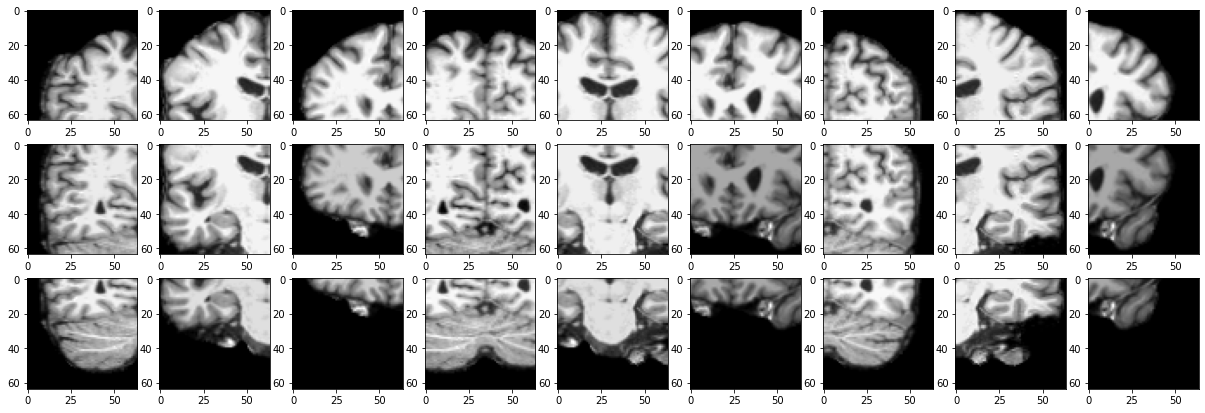

In [4]:
patches = process_scan('Train_CN/OAS30015_MR_d0116.mgz')
fig = plt.figure(figsize=(21, 7))
columns = 9
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(patches[i-1][:, :, 32]), cmap="gray")
plt.show()

## Reading data

In [5]:
# Folder "Train_CN" consist of subjects who remained cognitively converters for the whole study.
Train_CN_paths = [
    os.path.join(os.getcwd(), "Train_CN", x)
    for x in os.listdir("Train_CN")
]

# Folder "Val_CN" consist of subjects who remained cognitively converters for the whole study.
Val_CN_paths = [
    os.path.join(os.getcwd(), "Val_CN", x)
    for x in os.listdir("Val_CN")
]

# Folder "Test_CN" consist of subjects who remained cognitively converters for the whole study.
Test_CN_paths = [
    os.path.join(os.getcwd(), "Test_CN", x)
    for x in os.listdir("Test_CN")
]


# Folder "Train_Converters" consist of subjects who converted from CN to MCI > 0.
Train_Converters_paths = [
    os.path.join(os.getcwd(), "Train_Converters", x)
    for x in os.listdir("Train_Converters")
]

# Folder "Val_Converters" consist of subjects who converted from CN to MCI > 0.
Val_Converters_paths = [
    os.path.join(os.getcwd(), "Val_Converters", x)
    for x in os.listdir("Val_Converters")
]

# Folder "Test_Converters" consist of subjects who converted from CN to MCI > 0.
Test_Converters_paths = [
    os.path.join(os.getcwd(), "Test_Converters", x)
    for x in os.listdir("Test_Converters")
]

print("MRI scans for patients remaining CN (Train): " + str(len(Train_CN_paths)))
print("MRI scans for patients remaining CN (Val): " + str(len(Val_CN_paths)))
print("MRI scans for patients remaining CN (Test): " + str(len(Test_CN_paths)))

print("MRI scans for patients converting to AD (Train): " + str(len(Train_Converters_paths)))
print("MRI scans for patients converting to AD (Val): " + str(len(Val_Converters_paths)))
print("MRI scans for patients converting to AD (Test): " + str(len(Test_Converters_paths)))

MRI scans for patients remaining CN (Train): 30
MRI scans for patients remaining CN (Val): 10
MRI scans for patients remaining CN (Test): 10
MRI scans for patients converting to AD (Train): 30
MRI scans for patients converting to AD (Val): 10
MRI scans for patients converting to AD (Test): 10


In [6]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
Train_CN_scans = np.array([process_scan(path) for path in Train_CN_paths])
Val_CN_scans = np.array([process_scan(path) for path in Val_CN_paths])
Test_CN_scans = np.array([process_scan(path) for path in Test_CN_paths])

Train_Converters_scans = np.array([process_scan(path) for path in Train_Converters_paths])
Val_Converters_scans = np.array([process_scan(path) for path in Val_Converters_paths])
Test_Converters_scans = np.array([process_scan(path) for path in Test_Converters_paths])

In [7]:
# For the converters assign 1, for the CN subjects assign 0.
Train_CN_labels = np.array([0 for _ in range(len(Train_CN_scans))])
Val_CN_labels = np.array([0 for _ in range(len(Val_CN_scans))])
Test_CN_labels = np.array([0 for _ in range(len(Test_CN_scans))])

Train_Converters_labels = np.array([1 for _ in range(len(Train_Converters_scans))])
Val_Converters_labels = np.array([1 for _ in range(len(Val_Converters_scans))])
Test_Converters_labels = np.array([1 for _ in range(len(Test_Converters_scans))])

Epoch 1/1000
6/6 - 40s - loss: 0.6971 - acc: 0.5000 - auc_1: 0.3539 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc_1: 0.5000


C:\Users\Justin\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/1000
6/6 - 3s - loss: 0.6939 - acc: 0.4000 - auc_1: 0.4500 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 3/1000
6/6 - 3s - loss: 0.6913 - acc: 0.5833 - auc_1: 0.5494 - val_loss: 0.6943 - val_acc: 0.5000 - val_auc_1: 0.3500
Epoch 4/1000
6/6 - 3s - loss: 0.6995 - acc: 0.4000 - auc_1: 0.4106 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 5/1000
6/6 - 3s - loss: 0.6947 - acc: 0.5167 - auc_1: 0.5172 - val_loss: 0.6934 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 6/1000
6/6 - 3s - loss: 0.6888 - acc: 0.6167 - auc_1: 0.5917 - val_loss: 0.6957 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 7/1000
6/6 - 3s - loss: 0.6693 - acc: 0.7000 - auc_1: 0.6378 - val_loss: 0.7337 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 8/1000
6/6 - 3s - loss: 0.7166 - acc: 0.5000 - auc_1: 0.4361 - val_loss: 0.7506 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 9/1000
6/6 - 3s - loss: 0.6887 - acc: 0.6333 - auc_1: 0.6094 - val_loss: 0.7184 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 10

KeyboardInterrupt: 

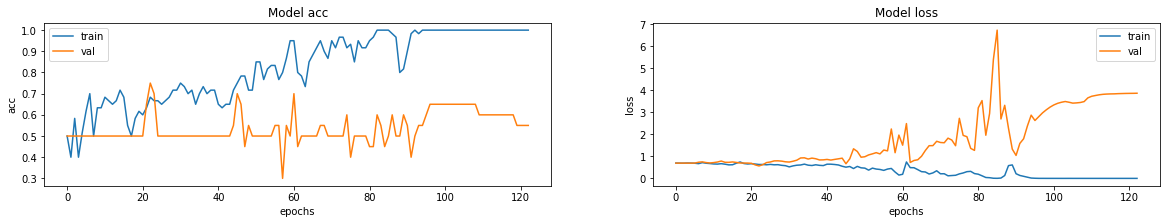

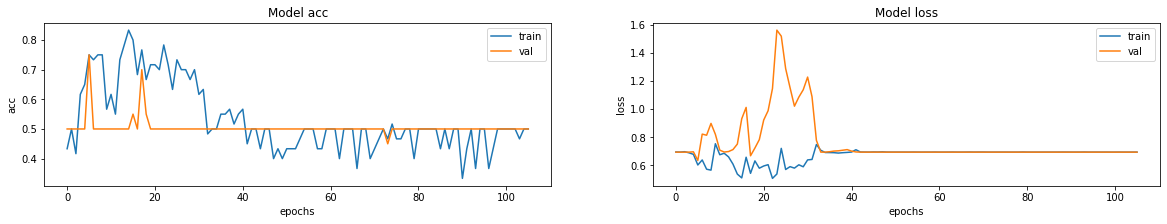

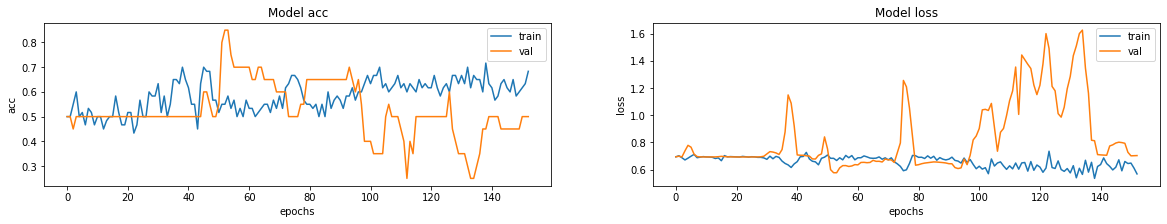

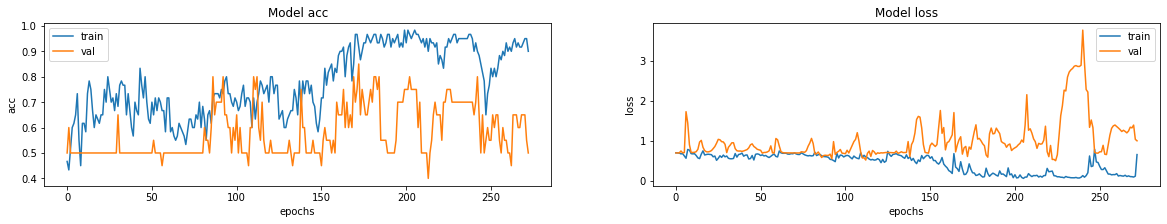

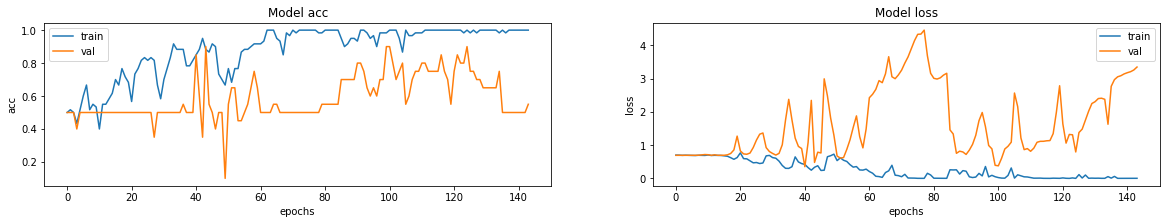

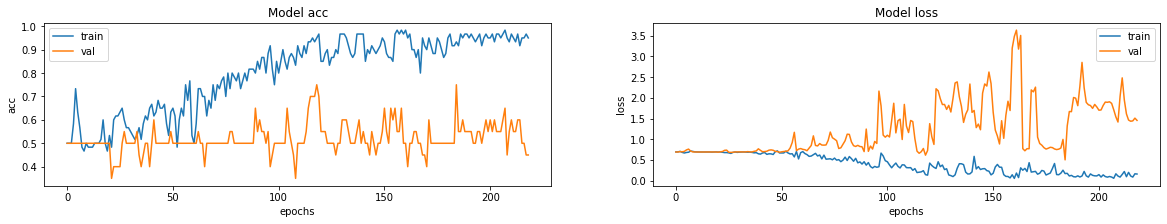

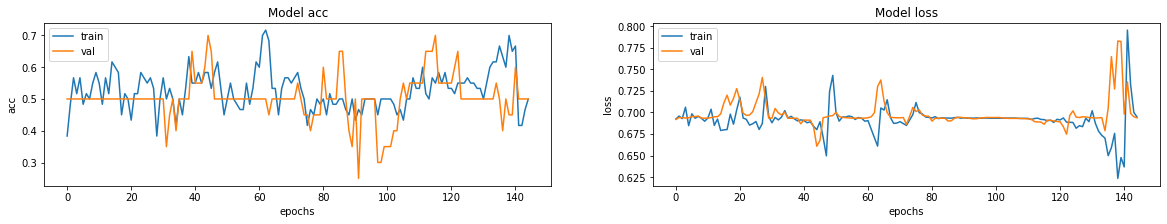

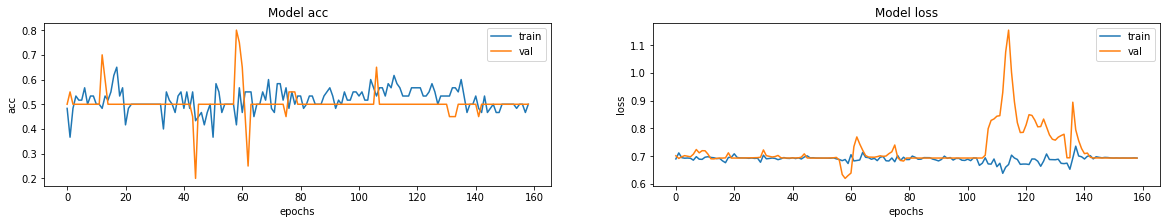

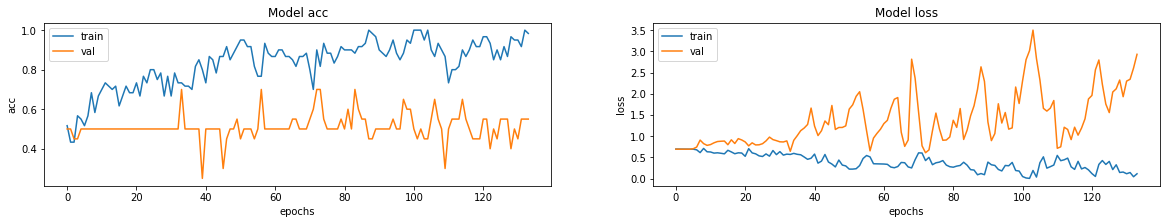

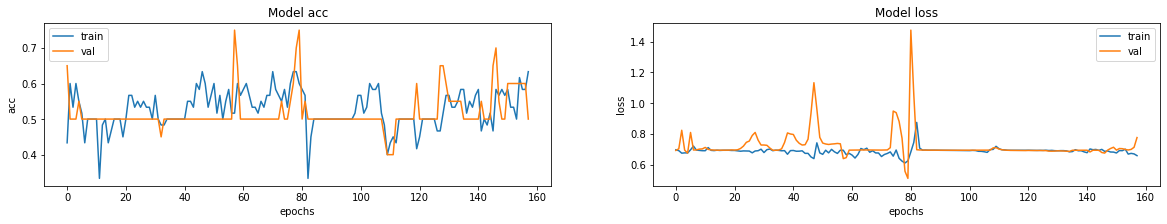

In [9]:
for i in range(27): # For all 27 of the patches
    # Read the patches from the processed scans.
    Train_CN_patches = np.array([scan[i,:,:,:] for scan in Train_CN_scans])
    Val_CN_patches = np.array([scan[i,:,:,:] for scan in Val_CN_scans])
    Test_CN_patches = np.array([scan[i,:,:,:] for scan in Test_CN_scans])
    Train_Converters_patches = np.array([scan[i,:,:,:] for scan in Train_Converters_scans])
    Val_Converters_patches = np.array([scan[i,:,:,:] for scan in Val_Converters_scans])
    Test_Converters_patches = np.array([scan[i,:,:,:] for scan in Test_Converters_scans])

    # Create x and y values for train, validation and test sets
    x_train = np.concatenate((Train_CN_patches, Train_Converters_patches), axis=0)
    x_val = np.concatenate((Val_CN_patches, Val_Converters_patches), axis=0)
    x_test = np.concatenate((Test_CN_patches, Test_Converters_patches), axis=0)
    y_train = np.concatenate((Train_CN_labels, Train_Converters_labels), axis=0)
    y_val = np.concatenate((Val_CN_labels, Val_Converters_labels), axis=0)
    y_test = np.concatenate((Test_CN_labels, Test_Converters_labels), axis=0)

    # Convert image data to RGB (3 channels) so ImageNet weights work
    x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
    x_val_rgb = np.repeat(x_val[..., np.newaxis], 3, -1)
    x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)

    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val_rgb, y_val))
    test_loader = tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test))

    batch_size = 10
    train_dataset = (
        train_loader.shuffle(len(x_train_rgb))
        .batch(batch_size)
        .prefetch(1)
    )
    validation_dataset = (
        validation_loader.shuffle(len(x_val_rgb))
        .batch(batch_size)
        .prefetch(1)
    )
    test_dataset = (
        validation_loader.shuffle(len(x_test_rgb))
        .batch(batch_size)
        .prefetch(1)
    )

    # for tensorflow.keras
    from classification_models_3D.tfkeras import Classifiers

    SEResNeXt50, preprocess_input = Classifiers.get('seresnext50')
    base_model = SEResNeXt50(input_shape=(64, 64, 64, 3), weights='imagenet')

    x = base_model.output
    x = tf.keras.layers.Dense(1000,activation='relu')(x) 
    x = tf.keras.layers.Dense(500,activation='relu')(x)
    x = tf.keras.layers.Dense(200,activation='relu')(x) 
    x = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)
    model = keras.Model(inputs = base_model.input, outputs = x)

    auc = tf.keras.metrics.AUC()  # instantiate it here to have a shorter handle

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["acc", auc],
    )

    # Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        str("SEResNeXt50/3d_image_classification"+str(i)+".h5"), save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=100)

    # Train the model, doing validation at the end of each epoch
    epochs = 1000
    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_cb, early_stopping_cb],
    )

    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, metric in enumerate(["acc", "loss"]):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])